# ATongs Model (Machine Learning)
# Capstone Project C241-PR548

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

import gdown.download
import shutil
import zipfile
import os

# Only if run on google colab
try:
    from google.colab import files
except:
    pass

## Utilities

In [3]:
def display_images(digits, predicted_labels, true_labels, label_str,title):
    """
    Display images with its labels

    Args:
        digits -- image item in array
        prediction -- prediction from the model (one-hot)
        labels -- ground truth label(s) (one-hot)
        label_str -- list of label name in string
        title -- title for matplotlib figure

    Returns:
        No returns
    """
    # Get image length
    n_image = len(digits)
    row_num = round(n_image / 4)
    x_fig = row_num

    # Create a grid based on image number for Image Comparison
    fig, axes = plt.subplots(row_num, 4, figsize=(10, x_fig))

    for i, ax in enumerate(axes.ravel()):
        # Continue if the enumeration index passes image length
        if i > n_image:
            continue
        # Show image in the pyplot figure
        ax.imshow(images[i])

        # Convert Numeric Labels to Alphanumeric Labels
        true_label = label_str[np.argmax(true_labels[i])]
        predicted_label = label_str[np.argmax(predicted_labels[i])]

        ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def load_image_tensor(path, shape=(224, 224), normalize=True):
    """
    Display images with its labels

    Args:
        path -- path to the image file
        shape -- image output shape
        normalize -- normalize the image array

    Returns:
        np_img -- return
    """
    img = load_img(path, target_size=shape)
    np_img = img_to_array(img)
    if normalize:
        np_img /= 255.
    return np_img

In [5]:
def get_dataset_path_from_drive(drive_id, dir):
    """
    Download and Get dataset path from google drive

    Args:
        drive_id -- file id when downloading from gdrive
        dir -- target directory to save the dataset

    Returns:
        dataset_local_folder -- path to dataset folder : str
    """
    # Check if the dataset exist in the directory
    if not os.path.exists(dir):
        temp_path = "temp.zip"
        gdown.download(f"https://drive.google.com/uc?id={drive_id}", temp_path, quiet=False)

        # Open the dataset from zipfile
        zip_ref = zipfile.ZipFile(temp_path, 'r')
        zip_ref.extractall(dir)
        zip_ref.close()
        os.remove(temp_path)

        print("Dataset downloaded at", dir)
    else:
        print("Dataset exist at", dir)
    return os.path.abspath(dir)

In [ ]:
# Spliting datasets to training and testing
def split_dir_train_test(src, dst, shuffle=True, force=False, train_split=0.8, verbose=False, skip_label=[]):
    """
    Split directory to train and test directory

    Args:
        src -- source directory for the dataset
        dst -- target directory to save the splited dataset
        shuffle -- shuffle the class directory for split
        force -- force to replace existing target directory
        train_split -- split size for the training split
        verbose -- output logs for every copied file(s)

    Returns:
        No returns
    """

    # Checking for the possible failing
    if not os.path.exists(src):
        print("Path", dst, "exist! Aborting.")
        return

    if os.path.exists(dst):
        if force:
            shutil.rmtree(dst)
            print("Deleted", dst)
            os.mkdir(dst)
        else:
            print("Path", dst, "exist! Aborting.")
            return
    else:
        os.mkdir(dst)

    classes = os.listdir(src)

    # Create destination training and testing dir
    train_dir = os.path.join(dst, "train")
    test_dir = os.path.join(dst, "test")
    os.mkdir(train_dir)
    os.mkdir(test_dir)

    # Iterate for every classes in the src directory
    for item_class in classes:
        # check for skipped class
        if item_class in skip_label:
            continue
        # Get every item in the source class directory
        item_dir = os.path.join(src, item_class)
        items = os.listdir(item_dir)
        if shuffle:
            np.random.shuffle(items)

        # Get the split for the training

        items_len = len(items)
        train_len = round(items_len * train_split)

        # split the items for train and test
        train_items = items[:train_len]
        test_items = items[train_len:]

        # Create train and test directory for the item class
        train_item_dir = os.path.join(train_dir, item_class)
        os.mkdir(train_item_dir)

        test_item_dir = os.path.join(test_dir, item_class)
        os.mkdir(test_item_dir)

        # iterate for every item according to the split
        print("Copying", item_dir, f"({train_len}, {items_len - train_len})")
        for item in train_items:
            src_item = os.path.join(item_dir, item)
            dst_item = os.path.join(train_item_dir, item)

            shutil.copy2(src_item, dst_item)
            if verbose:
                print(f"copied {src_item} to {dst_item}")

        for item in test_items:
            src_item = os.path.join(item_dir, item)
            dst_item = os.path.join(test_item_dir, item)

            shutil.copy2(src_item, dst_item)
            if verbose:
                print(f"copied {src_item} to {dst_item}")

## Prepare datasets

### Dataset Garbage Classification
* Reduce the class to 8 classes

In [ ]:
dataset_id = "1XJ49MLD83_UG7uLn81BoMvjOFmdkyOud"
dir_path = "dataset"

# Download and retrieve dataset path from the google drive
dataset_path = get_dataset_path_from_drive(dataset_id, dir_path)

Downloading...
From (original): https://drive.google.com/uc?id=1XJ49MLD83_UG7uLn81BoMvjOFmdkyOud
From (redirected): https://drive.google.com/uc?id=1XJ49MLD83_UG7uLn81BoMvjOFmdkyOud&confirm=t&uuid=e8984f1e-6e95-4b32-916f-e3dfb937657d
To: /content/temp.zip
100%|██████████| 251M/251M [00:04<00:00, 57.2MB/s]


Dataset downloaded at dataset


In [ ]:
# Combine Glass Labels
def combine_glass(dir_path):
    # Get the garbage classification directory
    dir_path = os.path.join(dir_path, "garbage_classification")
    new_glass_path = os.path.join(dir_path, "glass")
    print(new_glass_path)
    dir_list = os.listdir(dir_path)

    # Create new directory for the dataset
    os.mkdir(new_glass_path)

    # iterate in each directory in the garbage classification directory dataset
    for dir in dir_list:
        if "glass" in dir:
            print("Combining", dir)
            class_path = os.path.join(dir_path, dir)
            shutil.copytree(class_path, new_glass_path, dirs_exist_ok=True)
            shutil.rmtree(class_path)

try:
    combine_glass(dataset_path)
except:
    pass

/content/dataset/garbage_classification/glass
Combining green-glass
Combining brown-glass
Combining white-glass


In [ ]:
# Set the arguments for the split function
TRAIN_SPLIT = 0.9
SHUFFLE = True
SOURCE_PATH = os.path.join(dataset_path, "garbage_classification")
DESTINATION_PATH = os.path.join(dataset_path, "split")

In [ ]:
# Skip label
skip_list = ['battery', 'shoes']
# Split the dataset path for the train & dev sets
split_dir_train_test(SOURCE_PATH, DESTINATION_PATH, shuffle=SHUFFLE, train_split=TRAIN_SPLIT, skip_label=skip_list)

Copying /content/dataset/garbage_classification/plastic (778, 87)
Copying /content/dataset/garbage_classification/cardboard (802, 89)
Copying /content/dataset/garbage_classification/paper (945, 105)
Copying /content/dataset/garbage_classification/metal (692, 77)
Copying /content/dataset/garbage_classification/clothes (4792, 533)
Copying /content/dataset/garbage_classification/biological (886, 99)
Copying /content/dataset/garbage_classification/trash (627, 70)
Copying /content/dataset/garbage_classification/glass (1810, 201)


## Preprocess data

In [ ]:
# The image is splited between train and dev dir
train_dir = "/content/dataset/split/train"
dev_dir = "/content/dataset/split/test"

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1,
        fill_mode='nearest')

dev_datagen  = ImageDataGenerator( rescale = 1. /255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),)

# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------

dev_generator =  dev_datagen.flow_from_directory(dev_dir,
                                                 batch_size=20,
                                                 class_mode  = 'categorical',
                                                 target_size = (224, 224))

Found 11332 images belonging to 8 classes.
Found 1261 images belonging to 8 classes.


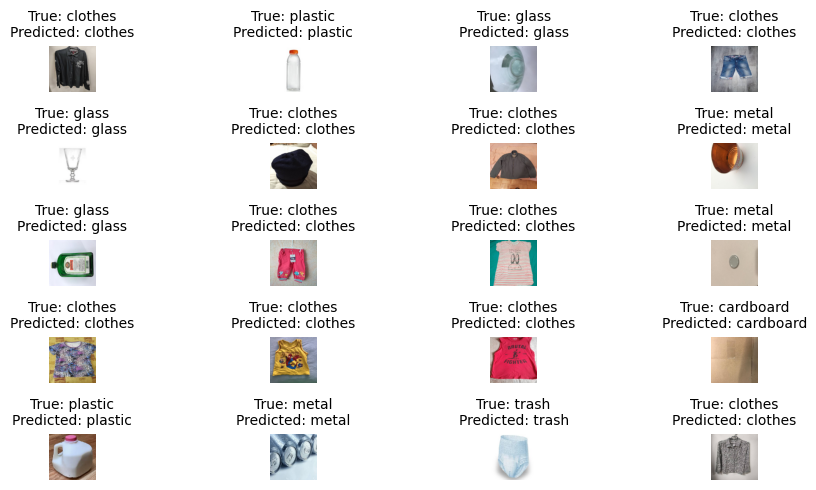

In [ ]:
# Showing some of the image in the dataset
images, labels = dev_generator.next()
display_images(images, labels, labels, ['biological', 'cardboard', 'clothes',
                       'glass', 'metal', 'paper', 'plastic', 'trash'], title="Testing dev images")

## Model building

### Feature Extraction Definition With MobileNetV2

In [ ]:
# Fetch MobileNetV2 feature extractor
from tensorflow.keras.applications import MobileNetV2

feature_extractor = MobileNetV2(input_shape=(224,224,3),
                                include_top=False,
                                weights='imagenet')

# Set all feature extractor layer to untrainable
for layer in feature_extractor.layers:
    layer.trainable = False

feature_extractor.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

### Feature Extraction Definition With ResNet50

In [ ]:
# Fetch MobileNetV2 feature extractor
from tensorflow.keras.applications import ResNet50V2

feature_extractor = ResNet50V2(input_shape=(224,224,3),
                                include_top=False,
                                weights='imagenet')

# Set all feature extractor layer to untrainable
for layer in feature_extractor.layers:
    layer.trainable = False

feature_extractor.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                        

### Checking the feature extractor layer

In [ ]:
# Get feature extractor output
# Comment the unused output layer

# final_layer = "out_relu" # MobileNetV2 Output Layer
final_layer = "post_relu" # ResNet50V2 Output Layer

fe_output_layer = feature_extractor.get_layer(final_layer)
fe_output = fe_output_layer.output
print('Feature extractor output shape: ', fe_output_layer.output_shape)
print('Feature extractor output: ', fe_output)

Feature extractor output shape:  (None, 7, 7, 2048)
Feature extractor output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='post_relu/Relu:0', description="created by layer 'post_relu'")


### Create Model V0.2 (MobileNetV2) & V0.3 (ResNetV2)
Changes:

V0.2
* V0.1 Flatten Layer -> GlobalAveragePooling2D
* Reduce model size to ~10% of V0.1 Model

V0.3
* V0.2 Feature Extractor -> ResNet50V2


In [ ]:
# Define Fully connected layer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = GlobalAveragePooling2D()(fe_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(128, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(12, activation='softmax')(x)

# Append the dense network to the base model
model = Model(feature_extractor.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

### Model architecture

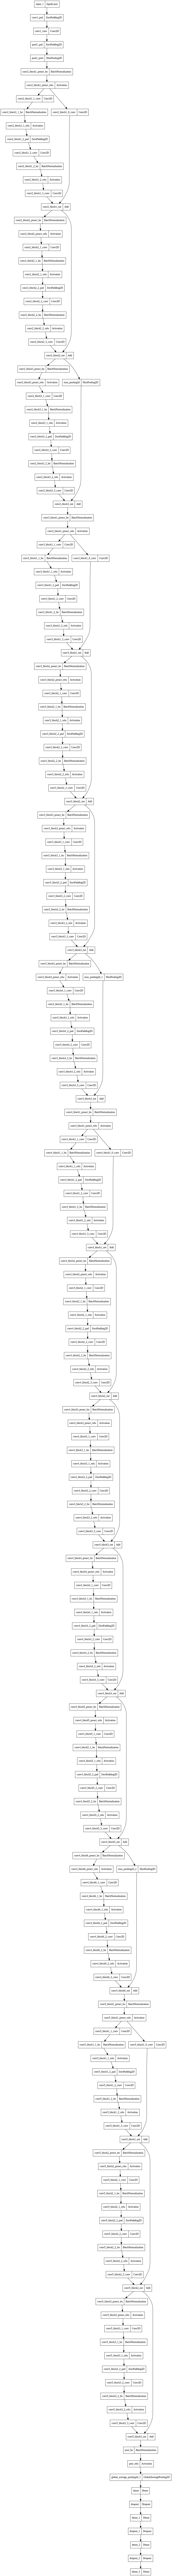

In [ ]:
tf.keras.utils.plot_model(model)

### Compile and Train Model

In [ ]:
# Compile the model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(
            train_generator,
            validation_data=dev_generator,
            epochs = 20)

Epoch 1/20
699/699 [==============================] - 256s 350ms/step - loss: 0.5983 - accuracy: 0.8124 - val_loss: 0.3914 - val_accuracy: 0.8758
Epoch 2/20
699/699 [==============================] - 230s 329ms/step - loss: 0.4089 - accuracy: 0.8766 - val_loss: 0.2870 - val_accuracy: 0.9054
Epoch 3/20
699/699 [==============================] - 230s 328ms/step - loss: 0.3585 - accuracy: 0.8901 - val_loss: 0.2861 - val_accuracy: 0.9144
Epoch 4/20
699/699 [==============================] - 231s 331ms/step - loss: 0.3279 - accuracy: 0.9044 - val_loss: 0.2700 - val_accuracy: 0.9067
Epoch 5/20
699/699 [==============================] - 231s 330ms/step - loss: 0.2948 - accuracy: 0.9105 - val_loss: 0.2700 - val_accuracy: 0.9183
Epoch 6/20
699/699 [==============================] - 225s 322ms/step - loss: 0.2707 - accuracy: 0.9173 - val_loss: 0.3198 - val_accuracy: 0.9022
Epoch 7/20
699/699 [==============================] - 227s 325ms/step - loss: 0.2710 - accuracy: 0.9181 - val_loss: 0.2535 -

## Model Evaluation

In [ ]:
# Save model and history
def download_history():
    import pickle

    model_name = "waste_model_classifier_resnet_v0.3.h5"
    history_name = f"history_{model_name[:-3]}"

    with open(history_name, 'wb') as f:
        pickle.dump(history.history, f)

    model.save(model_name)
    files.download(f'{history_name}')
    files.download(model_name)

# Check if its in the colab
try:
    download_history()
except:
    model.save("model/model.h5")

In [ ]:
# Disconnect from google colab runtime
try:
    from google.colab import runtime
    runtime.unassign()
except:
    pass

### Read history epoch from pickle

In [ ]:
history_drive_id = "1nTGB9khooGbRV2vaprtpNc6n6SOqhm5i"
model_drive_id = "1S_whLRK6NzAomr6Mwcc19uZsfF-ozqgz"

In [ ]:
import pandas as pd
import gdown.download

gdown.download(f"https://drive.google.com/uc?id={history_drive_id}", "history.pkl", quiet=False)
history = pd.read_pickle(r'history.pkl')

Downloading...
From: https://drive.google.com/uc?id=1nTGB9khooGbRV2vaprtpNc6n6SOqhm5i
To: /content/history.pkl
100%|██████████| 796/796 [00:00<00:00, 1.40MB/s]


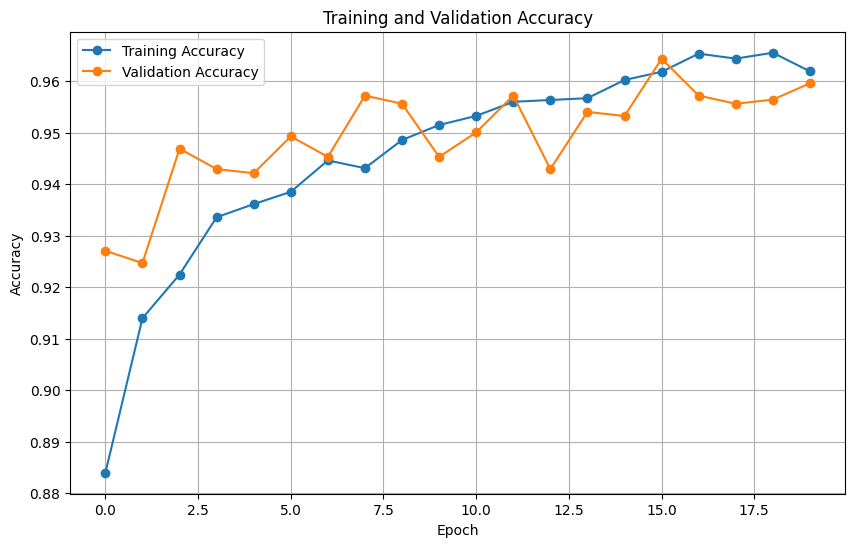

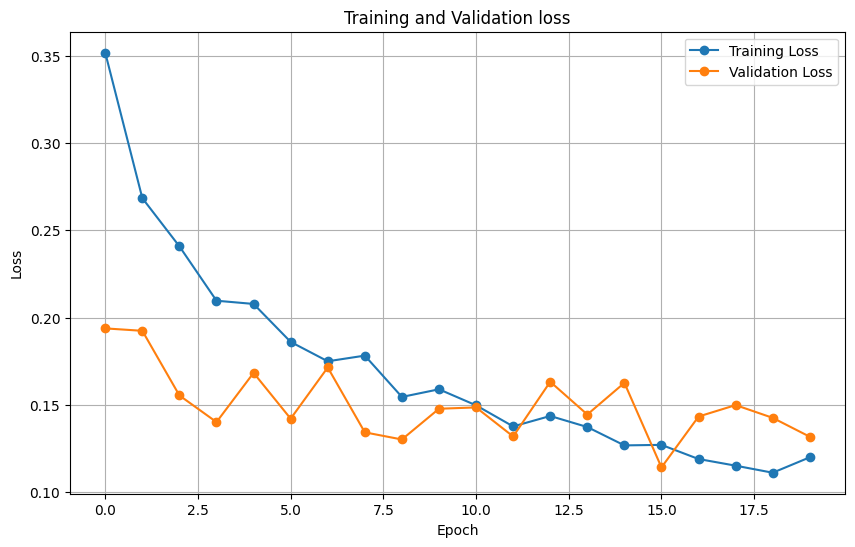

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history['accuracy']
val_acc=history['val_accuracy']
loss=history['loss']
val_loss=history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Download model from drive

In [ ]:
# Download the pretrained model
import gdown.download
gdown.download(f"https://drive.google.com/uc?id={model_drive_id}", "model.h5", quiet=False)
model = tf.keras.models.load_model("model.h5")

Downloading...
From (original): https://drive.google.com/uc?id=1S_whLRK6NzAomr6Mwcc19uZsfF-ozqgz
From (redirected): https://drive.google.com/uc?id=1S_whLRK6NzAomr6Mwcc19uZsfF-ozqgz&confirm=t&uuid=f9007315-8b15-4148-ad96-6af85ac8344f
To: /content/model.h5
100%|██████████| 127M/127M [00:00<00:00, 160MB/s]


In [ ]:
label_list = np.array(['biological', 'cardboard', 'clothes',
                       'glass', 'metal', 'paper', 'plastic', 'trash'])

1/1 [==============================] - 4s 4s/step


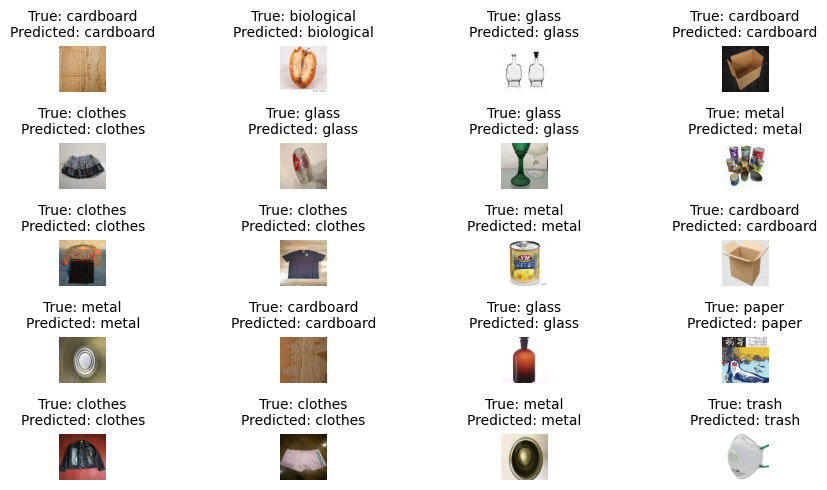

In [ ]:
images, y_true = dev_generator.next()
y_pred = model.predict(images)
display_images(images, y_pred, y_true, label_list, "Prediction list")

In [ ]:
# Read data from dev generator
batch_index = 0
y_pred_list = []
y_true_list = []
num_steps = 64
while batch_index <= num_steps:
    print("Step:", batch_index)
    images, y_true = dev_generator.next()
    y_pred = model.predict(images)
    y_pred_list.append(y_pred)
    y_true_list.append(y_true)
    batch_index += 1

Step: 0
1/1 [==============================] - 4s 4s/step
Step: 1
1/1 [==============================] - 3s 3s/step
Step: 2
1/1 [==============================] - 3s 3s/step
Step: 3
1/1 [==============================] - 4s 4s/step
Step: 4
1/1 [==============================] - 3s 3s/step
Step: 5
1/1 [==============================] - 4s 4s/step
Step: 6
1/1 [==============================] - 4s 4s/step
Step: 7
1/1 [==============================] - 3s 3s/step
Step: 8
1/1 [==============================] - 3s 3s/step
Step: 9
1/1 [==============================] - 4s 4s/step
Step: 10
1/1 [==============================] - 3s 3s/step
Step: 11
1/1 [==============================] - 6s 6s/step
Step: 12
1/1 [==============================] - 5s 5s/step
Step: 13
1/1 [==============================] - 7s 7s/step
Step: 14
1/1 [==============================] - 4s 4s/step
Step: 15
1/1 [==============================] - 3s 3s/step
Step: 16
1/1 [==============================] - 4s 4s/step
Step: 1

In [ ]:
def combine_batches(batches_list, one_hot=False):
    full_batch = np.array([])
    for batch in batches_list:
        for step in batch:
            if one_hot:
                import tensorflow as tf
                step = tf.math.argmax(step)
            full_batch = np.append(full_batch, step)
    return full_batch

In [ ]:
y_pred = combine_batches(y_pred_list, one_hot=True)
y_true = combine_batches(y_true_list, one_hot=True)
print(y_pred.shape, y_true.shape)

(1281,) (1281,)


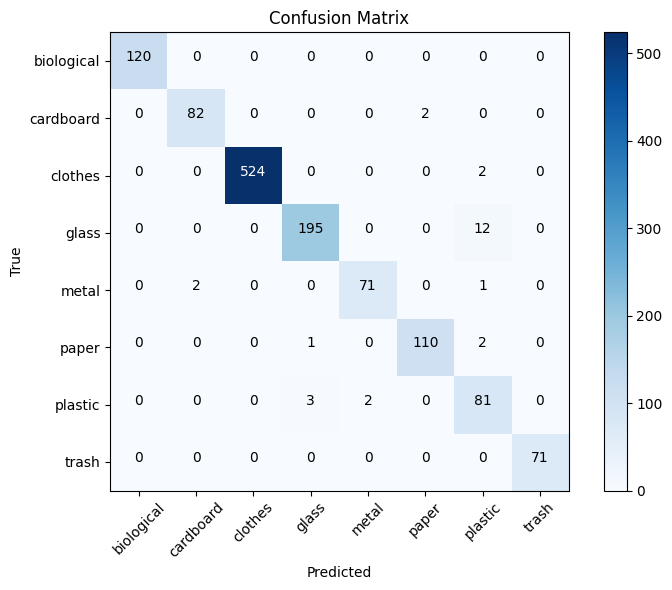

In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Define the Class
class_names = ['biological', 'cardboard', 'clothes',
                       'glass', 'metal', 'paper', 'plastic', 'trash']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()